# find out whether he/she donated blood in March 2007 (2 stands for donating blood; 1 stands for not donating blood)

In [22]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [3]:
data = fetch_openml("blood-transfusion-service-center")

In [5]:
data.data.head()

,V1,V2,V3,V4
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


In [8]:
data.target.head()

0    2
1    2
2    2
3    2
4    1
Name: Class, dtype: category
Categories (2, object): ['1', '2']

### First thing- we must split the data into training and test sets.
  by splitting the data we can have an objective look at the metrics 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=data.target, random_state=42)

## Exploring the Data
  Let's see how the data is structured. we need to know if any of the data is skewed and what kind of transformation we need to add

In [13]:
X_train.describe()

,V1,V2,V3,V4
count,561.000000,561.000000,561.000000,561.000000
mean,9.500891,5.643494,1410.873440,35.301248
std,8.181016,5.816341,1454.085176,24.721379
min,0.000000,1.000000,250.000000,2.000000
25%,2.000000,2.000000,500.000000,16.000000
50%,8.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


The describe tells us that all the values are numerical. Not only that, it also tells us that the values are not on the same scale in relation to eachtoher. Our model might prioitize column "V3" because the max value is 12500. Meaning it might see that as column of high importance. to avoid this we may need to use standard scaler to normalize all the data.

#### Histograms: to understand the distribution of each feature 

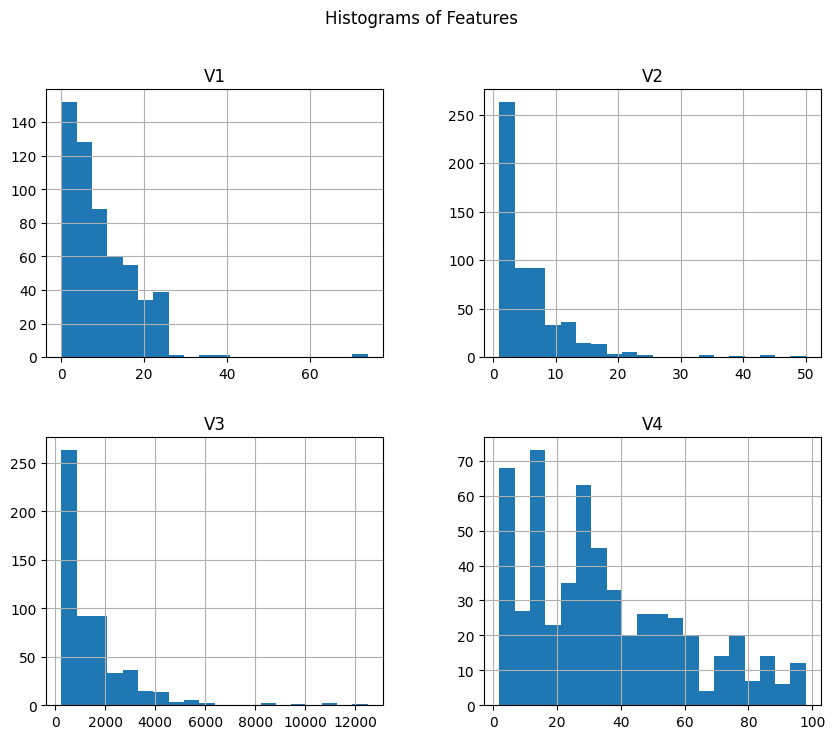

In [16]:
import matplotlib.pyplot as plt
X_train.hist(bins=20, figsize=(10,8))
plt.suptitle('Histograms of Features')
plt.show()

From this visual we can see that v1, v2, and v3 are all right tailed skewed. Normalizing all the features will help with the distribution of all the data. 

#### Pair plots: to see relationship between all pairs of features

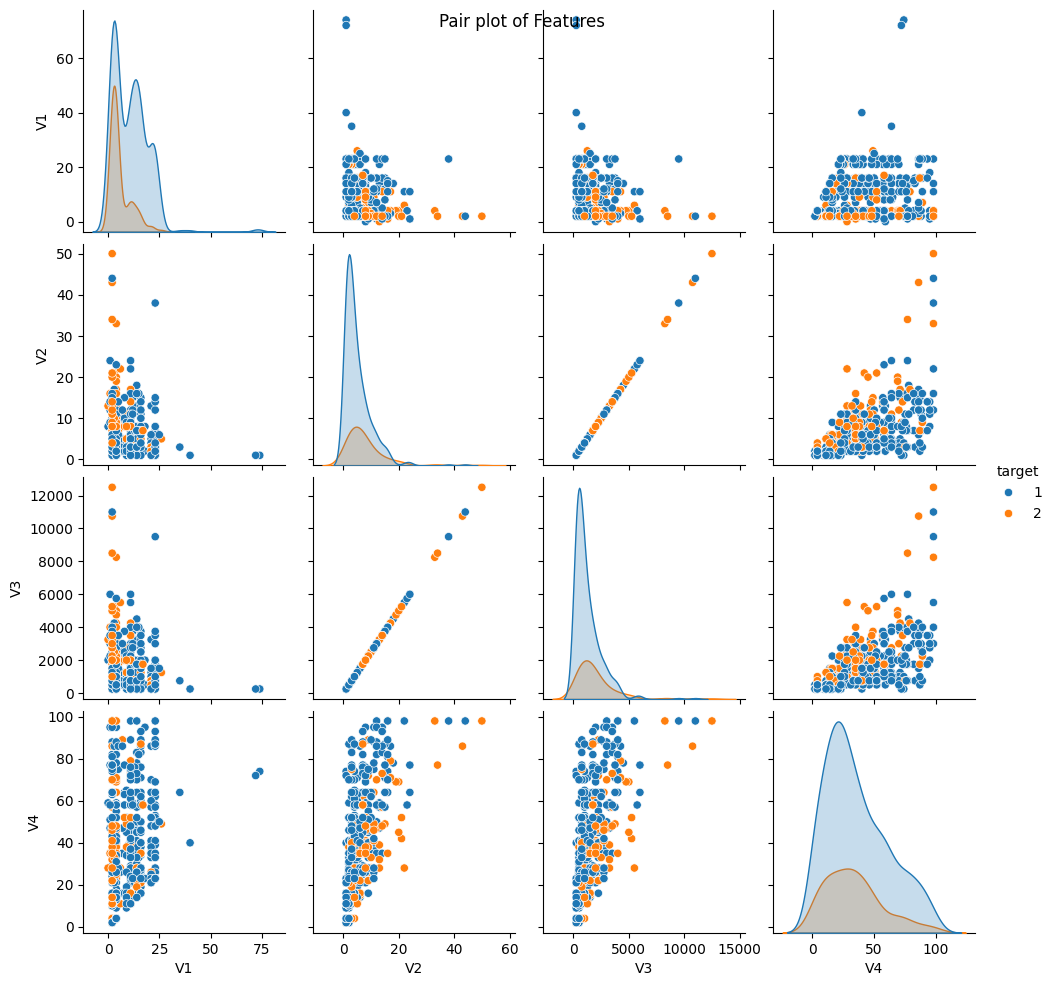

In [17]:
import seaborn as sns
x = X_train.copy()
x['target'] = y_train
sns.pairplot(x, hue='target')
plt.suptitle("Pair plot of Features")
plt.show()

#### Box plots: To identify outliers and understand the spread of the data

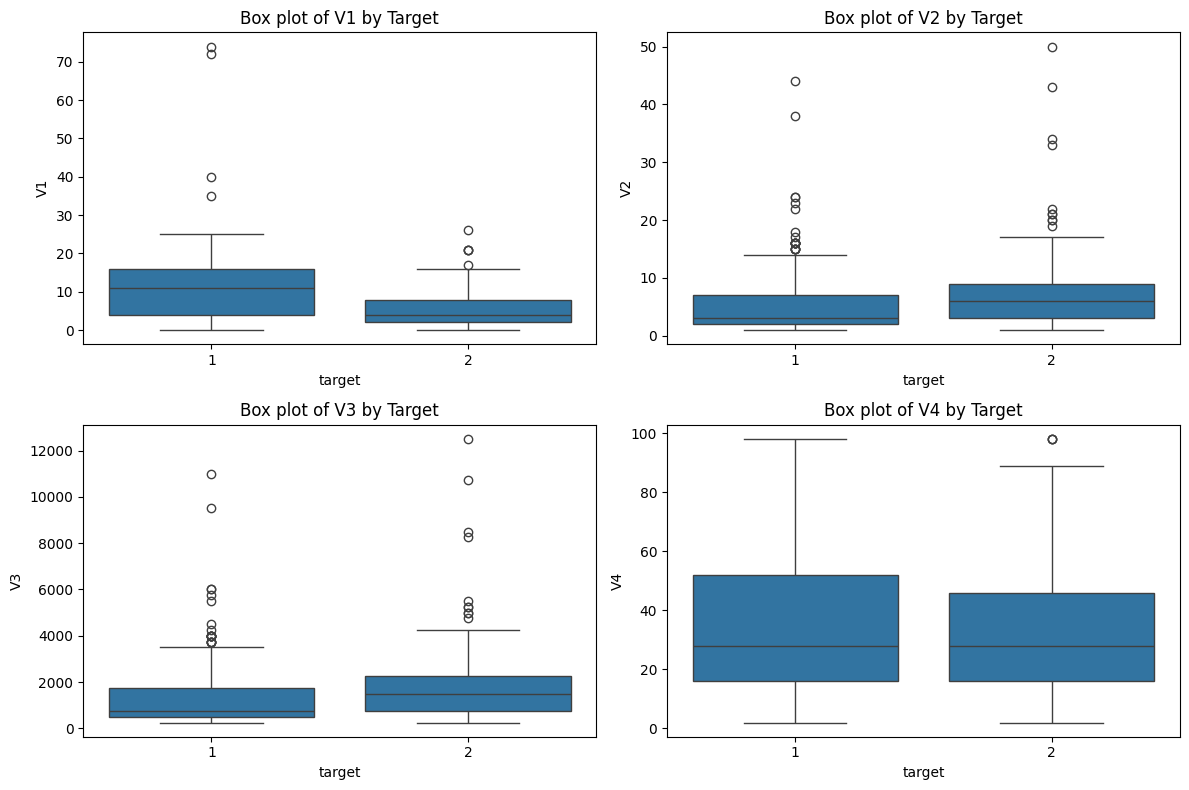

In [39]:
plt.figure(figsize=(12,8))
for i, column in enumerate(x.columns[:-1], 1):
    plt.subplot(2,2, i)
    sns.boxplot(x='target', y=column, data=x)
    plt.title(f'Box plot of {column} by Target')
plt.tight_layout()
plt.show()


#### Correlation Matrix to see how features are correlated with each other

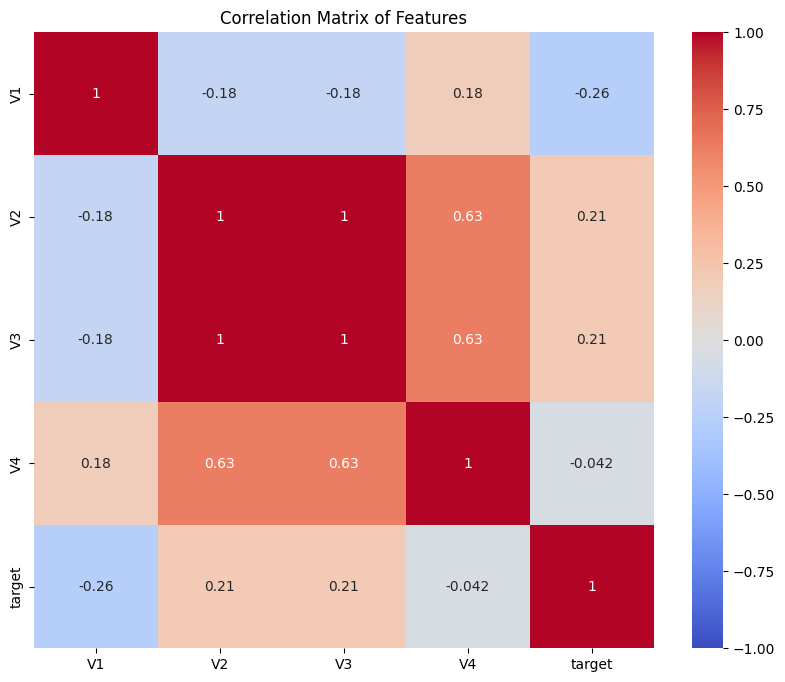

In [41]:
plt.figure(figsize=(10, 8))
corr_matrix = x.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

## Building pipeline 

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# define a log transformation function
def log_transform(X):
    return np.log1p(X)

pipeline = make_pipeline(FunctionTransformer(log_transform),
                         StandardScaler())


In [34]:
features = ['V1', 'V2', 'V3', 'V4']
scaler = pipeline.fit(X_train)
x_train_scaler = scaler.transform(X_train)
x_train_scaler_df = pd.DataFrame(x_train_scaler, columns=features)

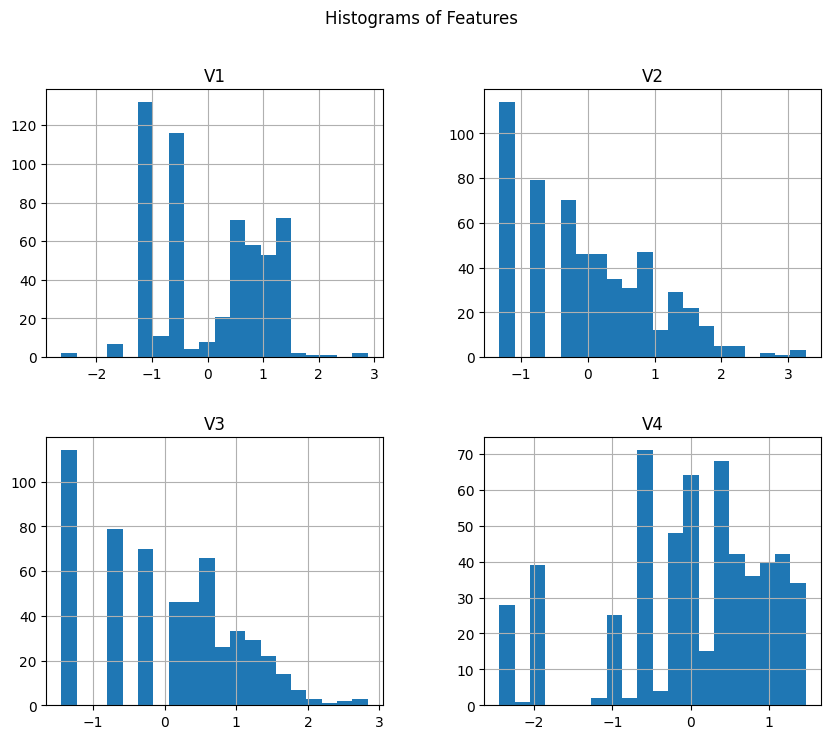

In [36]:
x_train_scaler_df.hist(bins=20, figsize=(10,8))
plt.suptitle('Histograms of Features')
plt.show()

## Building the model
  Now that we have the data scaled and normalized by using the log function. I will build 3 models. the model that performs the best with the lest tuning will move on to tuning for better metrics 

In [48]:
from sklearn.model_selection import cross_val_score

In [51]:
from sklearn.linear_model import LogisticRegression # simple, efficient and often performs well on small datasets

# define the model 
log_reg = LogisticRegression()

# train and evaluate the logistics model
log_reg.fit(x_train_scaler_df, y_train)
log_reg_score = cross_val_score(log_reg, x_train_scaler_df, y_train, cv=5, scoring='accuracy')
print(f'Logistic Regression accuracy: {log_reg_score.mean()} ± {log_reg_score.std()}')

Logistic Regression accuracy: 0.7754108723135273 ± 0.024767480871754507


In [52]:
from sklearn.svm import SVC # Effective in high - dimensional spaces and with small datasets 

svm = SVC(kernel='rbf', gamma='auto')
svm.fit(x_train_scaler_df, y_train)
svm_score = cross_val_score(svm, x_train_scaler_df, y_train, cv=5, scoring='accuracy')
print(f'svm accuracy: {log_reg_score.mean()} ± {log_reg_score.std()}')

Logistic Regression accuracy: 0.7754108723135273 ± 0.024767480871754507


In [53]:
from sklearn.neighbors import KNeighborsClassifier # Simple and intuitive algorithm that can perform well with small datasets

knn = KNeighborsClassifier( n_neighbors=2)
knn.fit(x_train_scaler_df, y_train)
knn_score = cross_val_score(knn, x_train_scaler_df, y_train, cv=5, scoring='accuracy')
print(f'KNN accuracy: {log_reg_score.mean()} ± {log_reg_score.std()}')

KNN accuracy: 0.7754108723135273 ± 0.024767480871754507


In [55]:
# Evaluate on test set
log_reg_test_score = log_reg.score(X_test, y_test)
svm_test_score = svm.score(X_test, y_test)
knn_test_score = knn.score(X_test, y_test)

print(f'Logistic Regression Test Accuracy: {log_reg_test_score}')
print(f'SVM Test Accuracy: {svm_test_score}')
print(f'k-NN Test Accuracy: {knn_test_score}')

Logistic Regression Test Accuracy: 0.23529411764705882
SVM Test Accuracy: 0.7647058823529411
k-NN Test Accuracy: 0.7647058823529411


## Initial model resutls 
  We can see that both the SVM nad the KNN are very close when it comes to the test set. the logisitcs regressor did very poor. 
  I will be hyperparameter tuning on boht the SVM and the KNN since they showed to be very promising so far 

In [58]:
# gridsearch for SVM
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C' : [0.1, 0.3, 0.5, 0.8, 1],
    'degree' : [2, 3, 5], 
    'gamma' : ['auto']
}

grid_search = GridSearchCV(svm, param_grid=param_grid, scoring= 'accuracy', cv=5, n_jobs=10)
grid_search.fit(x_train_scaler_df, y_train)

#Display the best parameters and best score 
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best recall score: {grid_search.best_score_}')

Best parameters: {'C': 1, 'degree': 2, 'gamma': 'auto'}
Best recall score: 0.7789823008849558


In [60]:

param_grid = {
    'n_neighbors': [2, 3, 4],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(knn, param_grid= param_grid, scoring='accuracy', cv=5, n_jobs=10)
grid_search.fit(x_train_scaler_df, y_train)

#Display the best parameters and best score 
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best recall score: {grid_search.best_score_}')

Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 4}
Best recall score: 0.7628634639696588
